In [1]:
import pandas as pd
from tqdm import tqdm
from top2vec import Top2Vec
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from pathlib import Path
import yaml 
import os

from helpers.linkage import *
from helpers import dataloader
from helpers.afa import adaptive_filter
from helpers.visuals import add_cabinet_periods
from helpers import metrics as mc
from helpers import infodynamics
from helpers.tools import *

from collections import Counter

2023-08-12 15:07:24.414188: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-12 15:07:24.416116: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-12 15:07:24.452239: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-12 15:07:24.452846: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-12 15:07:25.335054: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
# Use dataloader

data = pd.read_csv('/home/rb/Documents/Data/models/lda/full-postwar/data-speech-level-full.tsv',sep='\t')
dists = pd.read_csv('/home/rb/Documents/Data/models/lda/full-postwar/dists-speech-bound-250',sep='\t')
words = pd.read_csv('/home/rb/Documents/Data/models/lda/full-postwar/keys-speech-bound-250',sep='\t')

dists.index = pd.to_datetime(data.date,infer_datetime_format=True)

In [4]:
lbs = dict(zip(words.index,words.label))

In [8]:
dists = dists[[str(i) for i,l in lbs.items() if 'proc' not in l and 'rhet' not in l and 'nonse' not in l]]
dists = dists.div(dists.sum(axis=1), axis=0)

In [10]:
dists = dists.groupby(dists.index).mean()

In [11]:
# Novelty
theta = dists.to_numpy()
timestamps = dists.index.tolist()
w = 25
im = infodynamics.InfoDynamics(theta,timestamps,w)
im = im.fit_return(meas=mc.jsd)
imd = pd.DataFrame(im)
imd['date'] = timestamps
imd['n_afa'] = adaptive_filter(imd.novelty,span=100)
imd['r_afa'] = adaptive_filter(imd.resonance,span=100)

In [12]:
imd['date'] = sorted(list(set(dists.index)))

<AxesSubplot: xlabel='date'>

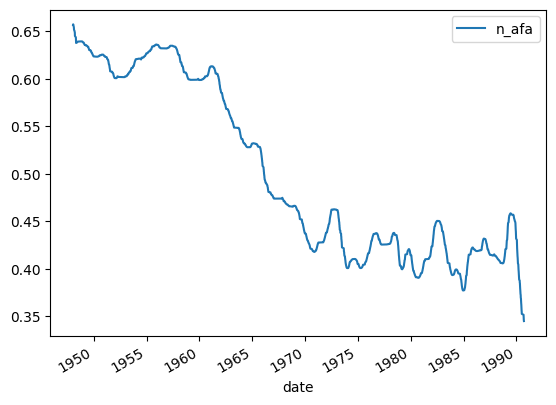

In [14]:
imd[imd.date.dt.year > 1947].plot(x='date',y='n_afa')

In [5]:
# Load members
mbs = pd.read_csv('helpers/members.csv',sep='\t')
name_id_dict = dict(zip(mbs.name,mbs.id))
id_name_dict = dict(zip(mbs.id,mbs.name))

In [6]:
dists = dists.reset_index()
dists['role'] = data['role']
dists['mb'] = data['member-ref']
dists = dists.set_index('date')

r = []
for (y,h),d_ in tqdm(dists.groupby([dists.index.year,(dists.index.month-1)//6])):
    roledict = dict(zip(d_.mb,d_.role))
    p_i_ = {m:c / len(d_) for m,c in d_.mb.value_counts().to_dict().items() if c > 10 and m != 'na'}
    p_j_ = d_.iloc[:,:-2].mean().to_dict()
    for mb in p_i_.keys():
        dmb = d_[d_.mb == mb]
        name = id_name_dict[mb]
        p_ij_ = {t:p * p_i_[mb] for t,p in dmb.mean().to_dict().items()}
        pmi_ = {t:np.log((pij) / (p_i_[mb] * p_j_[t])) for t,pij in p_ij_.items()}

        for k,v in pmi_.items():
            r.append({"date":pd.Timestamp(year=y,month=1 if h == 0 else 6, day=1),"mb":name,"topic":'\n'.join(words.words[int(k)].split(' ')[:5]),"pmi":v,'role':roledict[mb]})
rd = pd.DataFrame(r)

  1%|          | 1/91 [00:00<00:29,  3.10it/s]/tmp/ipykernel_518/2078209699.py:14: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  p_ij_ = {t:p * p_i_[mb] for t,p in dmb.mean().to_dict().items()}
/tmp/ipykernel_518/2078209699.py:14: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  p_ij_ = {t:p * p_i_[mb] for t,p in dmb.mean().to_dict().items()}
  3%|▎         | 3/91 [00:00<00:17,  5.05it/s]/tmp/ipykernel_518/2078209699.py:14: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will 

In [10]:
for hy,_ in rd.groupby('date'):
    continue

In [11]:
_ = _.pivot(index='mb',columns='topic',values='pmi').to_numpy()
ptj_i = p_ij / pt_i
Ri = (R_ij * ptj_i).sum(axis=0)
M = (Ri * pt_i).sum(axis=0)  

,date,mb,topic,pmi,role
2053500,1990-06-01,Drs. W.J. (Wilbert) Willems,kamer\npolitiek\nverantwoordelijkheid\nenquete...,0.376756,mp
2053501,1990-06-01,Drs. W.J. (Wilbert) Willems,kamer\nmotie\nregering\ndag\norde,0.648684,mp
2053502,1990-06-01,Drs. W.J. (Wilbert) Willems,werkloos\nwerkgelegenheid\nsociaal\narbeid\nwe...,-1.983282,mp
2053503,1990-06-01,Drs. W.J. (Wilbert) Willems,doelstelling\ndienen\ngroot\nontwikkeling\nbelang,-0.104252,mp
2053504,1990-06-01,Drs. W.J. (Wilbert) Willems,regering\ngaan\npolitiek\ngroot\njaar,0.627995,mp
...,...,...,...,...,...
2068495,1990-06-01,H. (Minouche) Janmaat-Abee,inkomen\nuitkering\nminima\necht\nmens,-2.024476,mp
2068496,1990-06-01,H. (Minouche) Janmaat-Abee,overheid\nverantwoordelijkheid\ntaak\nsamenlev...,0.087459,mp
2068497,1990-06-01,H. (Minouche) Janmaat-Abee,landbouw\nagrarisch\nbedrijf\nsector\nboer,-2.851784,mp
2068498,1990-06-01,H. (Minouche) Janmaat-Abee,ontwikkeling\nbedrijfsleven\noverheid\ntechnol...,-1.668066,mp


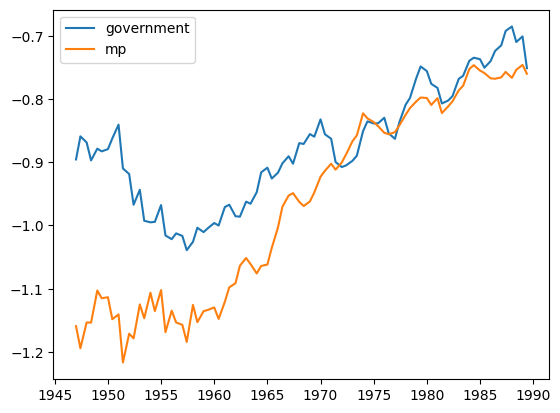

In [9]:
fig,ax = plt.subplots(1,1)

for c,(role,g) in enumerate(rd.groupby('role')):
    g = g[['pmi','date']].groupby('date').mean().reset_index()
    ax.plot(g.date,g.pmi.rolling(5,center=True).mean(),label=role)
ax.legend(loc='best')
plt.savefig('/home/rb/Desktop/mi-member-topic-role.png',dpi=250)
plt.show()

In [143]:
adgs_ = []
for y,d_ in rd.groupby('date'):

    for r,d2 in d_.groupby('role'):
        for i in np.arange(0,4,.25):
            d_r = d_[d_.pmi > i]
            B = nx.from_pandas_edgelist(d_r.reset_index(drop=True), "mb", "topic", edge_attr='pmi', create_using=nx.Graph())
            dgs = {m:d for m,d in dict(B.degree()).items() if '\n' not in m}
            adgs = np.mean(np.array(list(dgs.values())))
            adgs_.append([y,adgs,str(i),r])

ad = pd.DataFrame(adgs_,columns=['y','d','t','r'])
adn = []
for (t),g in ad.groupby(['t']):
    g = g.dropna()
    g['d'] = zscore(g['d'])
    adn.append(g)
adn = pd.concat(adn)

In [149]:
ad = pd.DataFrame(adgs_,columns=['y','d','t','r'])
adn = []
for (t),g in ad.groupby(['t']):
    g = g.dropna()
    g['d'] = zscore(g['d'])
    adn.append(g)
adn = pd.concat(adn)

<AxesSubplot: xlabel='y', ylabel='d'>

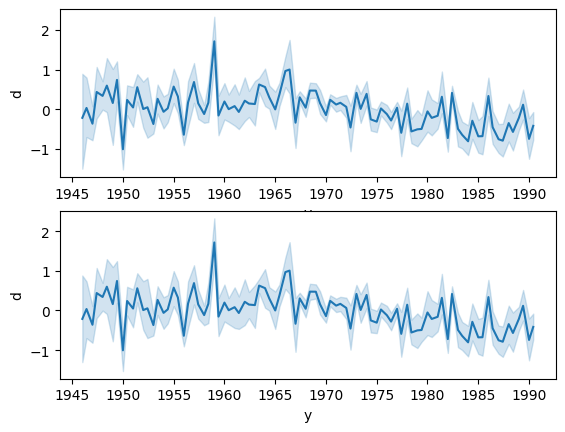

In [150]:
fig,ax = plt.subplots(2,1)
sns.lineplot(data=adn[adn.r == 'government'],x='y',y='d',ax=ax[0])
sns.lineplot(data=adn[adn.r == 'mp'],x='y',y='d',ax=ax[1])

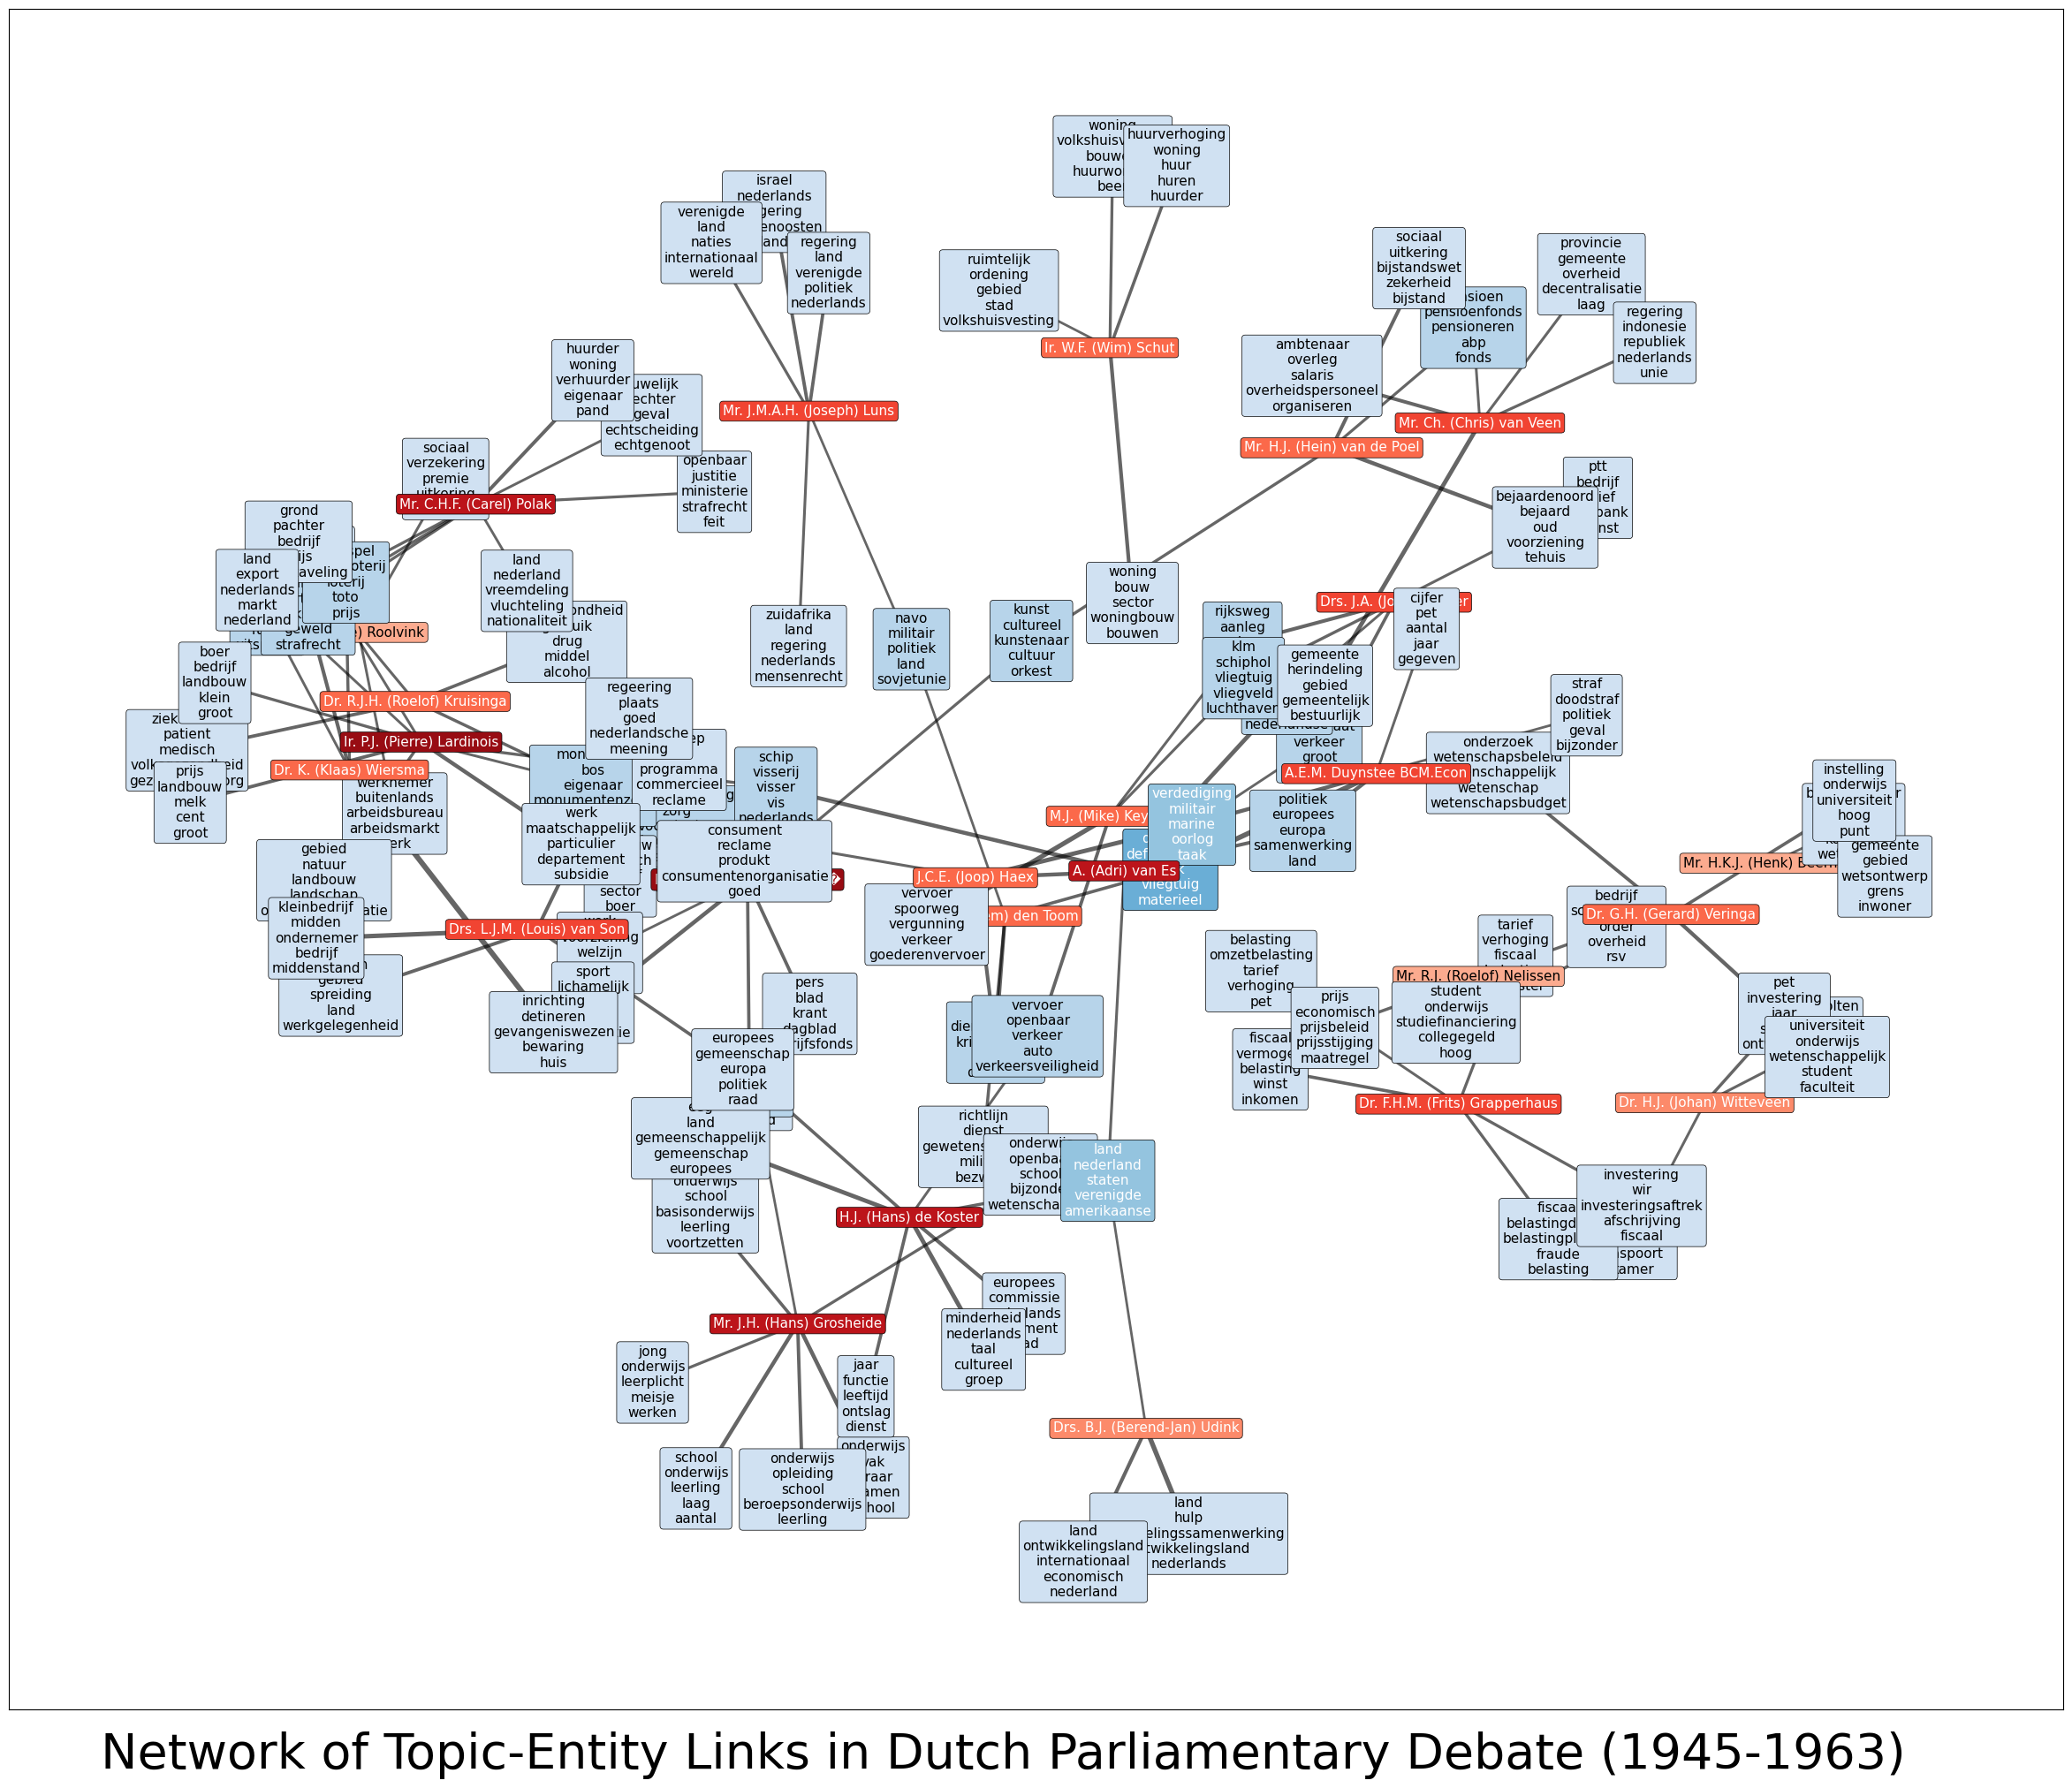

In [94]:
B = nx.from_pandas_edgelist(rn.reset_index(drop=True), "mb", "topic", edge_attr='pmi', create_using=nx.Graph())
pos = nx.spring_layout(B,iterations=120,k=.55)
wgs = [i['pmi'] for i in dict(B.edges).values()]

npos = {} 

label_ratio = 1.0/8.0
for aNode in B.nodes():
    x,y = pos[aNode]
    N = B[aNode]
    cx = sum(map(lambda x:pos[x][0], N)) / len(pos)
    cy = sum(map(lambda x:pos[x][1], N)) / len(pos)
    slopeY = (y-cy)
    slopeX = (x-cx)
    npos[aNode] = (x+slopeX*label_ratio, y+slopeY*label_ratio)


d = dict(B.degree)
pall_1 = sns.color_palette('Blues',max(d.values())+1)
pall_2 = sns.color_palette('Reds',max(d.values())+1)

fig = plt.figure(figsize=(30,25))
nx.draw_networkx_edges(B,npos,alpha=.6,width=wgs)
for node,position in npos.items():
    plt.annotate(node,
                 xy=position,
                 va='center',
                 ha='center',
                 color='black' if d[node] < 3 else 'white',
                 fontsize=11,
                 bbox=dict(facecolor=pall_1[d[node]] if '\n' in node else pall_2[d[node]],
                           linewidth=0.5, 
                           boxstyle='round,pad=.25', 
                           alpha=1 if len(node.split(' ')) < 5 else 1),
                 zorder=1,
                 alpha=1 if len(node.split(' ')) < 5 else 1) 


plt.suptitle('Network of Topic-Entity Links in Dutch Parliamentary Debate (1945-1963)',fontsize=40,y=0.1)
# plt.title('K = 100, POS = ADJ/N/VERB, WORD WEIGHT THRESHOLD = 5, DEGREE CENTRALITY THRESHOLD = 1',y=1,pad=-50,fontsize=20)
# plt.savefig(os.path.join(cf['project_path'],'figs','topic-entity-network.pdf'),dpi=300) 
plt.show()

In [154]:
rz = rd[rd.mb == 'Dr. J. (Jelle) Zijlstra']

In [156]:
adgs_ = []
for y,d_ in rz.groupby('date'):

    for r,d2 in d_.groupby('role'):
        for i in np.arange(0,4,.25):
            d_r = d_[d_.pmi > i]
            B = nx.from_pandas_edgelist(d_r.reset_index(drop=True), "mb", "topic", edge_attr='pmi', create_using=nx.Graph())
            dgs = {m:d for m,d in dict(B.degree()).items() if '\n' not in m}
            adgs = np.mean(np.array(list(dgs.values())))
            adgs_.append([y,adgs,str(i),r])

ad = pd.DataFrame(adgs_,columns=['y','d','t','r'])
adn = []
for (t),g in ad.groupby(['t']):
    g = g.dropna()
    g['d'] = zscore(g['d'])
    adn.append(g)
adn = pd.concat(adn)

<AxesSubplot: xlabel='y', ylabel='d'>

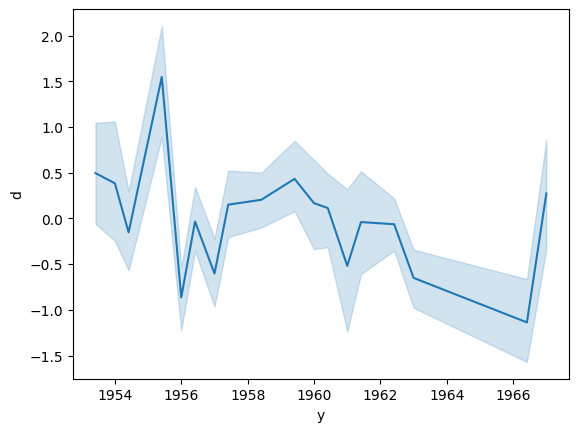

In [158]:
sns.lineplot(data=adn,x='y',y='d')